<a href="https://colab.research.google.com/github/jeromepatel/AIcrowd-challenges/blob/master/%5BExplainer%5D_Seismic_Facies_Identification_W%26B_with_Extra_Attributes%2C_Some_EDA_and_Catalyst_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seismic Facies Identification Challenge - Explainer Notebook with Added Perks
 **- Jyot Makadiya**

In this notebook, we are going to look at Seismic Facies Identification challenge which is a 3D semantic segmentation problem and with some tweaking, can be converted into 2D semantic segmentation task. 
This notebook aims to give an idea about previous work (notebooks at [this page](https://www.aicrowd.com/challenges/seismic-facies-identification-challenge/notebooks)) and summarizes a few very basic EDA, extra attibutes ideas and finally introduces a flexible and systemic approach for training models and tracking progress. 
* <b>What is 2D semantic segmentation?</b> </br>
 In simple words, semantic segmentation is a image recognition challenge with some perks where each pixel a class needs to be identified and tagged instead of whole image, so what we get in the end is a mask the size of original image segmented into different classes. As we all know, it requires a lot of data, different tools are used to prepared the dataset for segmentation maps from images.  
* **what is w&B ?**
 weights and biases is a free service and set of tools which provide easy tracking of all data science experiments along with the data visualization tools, in this notebook, we present very simple level introduction to wandb for only loss,accuracy vis but it can be further extended to store hyperparameter info, saving models etc. 
* **What is smp and why we are using it ?**
Segmentation models pytorch is package which provides pretrained well known segmentation architecture for suitable segmentation tasks. It is easy to use and easy to debug which makes it popular choice among researcher to initiate rapid experimentation with that. 
* **what is the need of preprocessing (in our case why augmentations and normalization)?**
I have tried to make this notebook well balanced between not too complex for preprocessing as well as enough to get a good score, basically, the preprocessing step is crucial in some tasks where there is a need for some performance improvement using some domain insights. The aim of augmentation is to get more data for training while reducing the overfitting effect. We applied normalization to make the train values even and not concentrated around same mean values. 



### Get dataset from colab

In [1]:
#getting the dataset from the drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install segmentation_models_pytorch argus pytorch_toolbelt wandb catalyst --upgrade albumentations

     |████████████████████████████████| 87 kB 3.3 MB/s 
     |████████████████████████████████| 69 kB 6.4 MB/s 
     |████████████████████████████████| 159 kB 17.3 MB/s 
     |████████████████████████████████| 1.7 MB 29.9 MB/s 
     |████████████████████████████████| 576 kB 24.0 MB/s 
     |████████████████████████████████| 102 kB 51.4 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
     |████████████████████████████████| 376 kB 45.3 MB/s 
     |████████████████████████████████| 139 kB 51.0 MB/s 
     |████████████████████████████████| 97 kB 7.1 MB/s 
     |████████████████████████████████| 180 kB 49.1 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 120 kB 48.4 MB/s 
     |████████████████████████████████| 596 kB 48.0 MB/s 
     |████████████████████████████████| 47.6 MB 36 kB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=0ac75d235a75f1bc5b4c35c493d7

In [3]:
!pip install git+https://github.com/gazprom-neft/seismiqb.git

  Cloning https://github.com/gazprom-neft/seismiqb.git to /tmp/pip-req-build-mjpw3gof
  Running command git clone -q https://github.com/gazprom-neft/seismiqb.git /tmp/pip-req-build-mjpw3gof
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 83 kB 1.6 MB/s 
     |████████████████████████████████| 790 kB 17.6 MB/s 
     |████████████████████████████████| 3.1 MB 26.7 MB/s 
     |████████████████████████████████| 296 kB 41.0 MB/s 
     |████████████████████████████████| 2.6 MB 33.7 MB/s 
     |████████████████████████████████| 280 kB 44.6 MB/s 
     |████████████████████████████████| 132 kB 43.6 MB/s 
     |████████████████████████████████| 374 kB 33.2 MB/s 
  Created wheel for seismiQB: filename=seismiQB-0.1.0-py3-none-any.whl size=602264 sha256=f12858e1e360382e497aa81d56155f9dfcd61bc3298dbc3aeca60ee9801fc136
  Stored in directory: /tmp/pip-ephem-wheel-cache-025omhjl/wheels/b3/90/9f/a8018f3983b2de90b64c2514a318cf521c2877c602d2dbff43
  Crea

## **Note: I already have dataset downloaded in my drive, so please make sure to put competition dataset over there and get the path for the dataset.**

In [4]:
#copy the dataset
!mkdir -p seismic-facies-identification-challenge
!rsync -avhW --compress-level=2 --info=progress2 /content/gdrive/MyDrive/Datasets/AIcrowd/seismic-facies-identification/data /content/seismic-facies-identification-challenge/data

sending incremental file list
created directory /content/seismic-facies-identification-challenge/data
data/
data/data_test_1.npz
        731.38M  13%   20.27MB/s    0:00:34 (xfr#1, to-chk=0/8)
data/data_test_2.npz
          1.78G  32%   20.16MB/s    0:01:24 (xfr#2, to-chk=5/8)
data/data_train.npz
          3.49G  63%   19.85MB/s    0:02:47 (xfr#3, to-chk=4/8)
data/data_train_processed.npz
          5.22G  95%   19.89MB/s    0:04:10 (xfr#4, to-chk=3/8)
data/labels_train.npz
          5.23G  95%   19.83MB/s    0:04:11 (xfr#5, to-chk=2/8)
data/sample_submission_1.npz
          5.33G  97%   19.59MB/s    0:04:19 (xfr#6, to-chk=1/8)
data/sample_submission_2.npz
          5.48G 100%   19.42MB/s    0:04:29 (xfr#7, to-chk=0/8)

sent 5.47G bytes  received 229 bytes  20.14M bytes/sec
total size is 5.48G  speedup is 1.00


## Importing packages/libraries
Import packages that are common for training and prediction phases here.

In [5]:
#importing libraries, fundamentals and EDA related
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import torch
torch.backends.cudnn.benchmark = True
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

import segmentation_models_pytorch as smp
# import argus
# from argus.callbacks import MonitorCheckpoint, EarlyStopping, LoggingToFile, ReduceLROnPlateau
# import albumentations as A
# from pytorch_toolbelt.inference.tiles import ImageSlicer, CudaTileMerger
# from pytorch_toolbelt.losses import LovaszLoss

In [6]:
#catalyst related imports
import os
from tempfile import TemporaryDirectory

from pytest import mark
from torch import nn, optim
from torch.utils.data import DataLoader

import catalyst
from catalyst import dl, utils, metrics
from catalyst.contrib.datasets import MNIST
from catalyst.data.transforms import ToTensor
from catalyst.settings import IS_CUDA_AVAILABLE, NUM_CUDA_DEVICES, SETTINGS

In [7]:
#misc imports
import albumentations as A

from copy import copy

import numpy as np
import matplotlib.pyplot as plt
import gc
import tqdm
import cv2

#setting the seed for catalyst
SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)


## Loading train and test dataset
we use numpy to get images/3D maps from compressed files

In [8]:
%%time
#loading training and test data
train_data_full = np.load('/content/seismic-facies-identification-challenge/data/data/data_train.npz', allow_pickle=True, mmap_mode='r')['data']
train_label_full = np.load('/content/seismic-facies-identification-challenge/data/data/labels_train.npz', allow_pickle=True, mmap_mode='r')['labels']

test_img = np.load('/content/seismic-facies-identification-challenge/data/data/data_test_2.npz', allow_pickle=True, mmap_mode='r')['data']


CPU times: user 23.5 s, sys: 4.36 s, total: 27.8 s
Wall time: 1min 9s


## EDA
Now let's take a look at the training data starting with basic info about data then plotting train data distribution w.r.t. mean +- 3 std and its log trasformation as well.

In [9]:
%%time
mean, std = train_data_full.mean(), train_data_full.std()

ranges = train_data_full.min(), train_data_full.max()
values = np.unique(train_label_full)

data_histograms = [train_data_full[train_label_full == value].flatten()
                   for value in values]


CPU times: user 41.8 s, sys: 2.31 s, total: 44.1 s
Wall time: 43.9 s


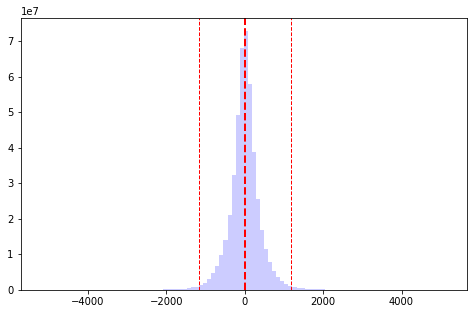

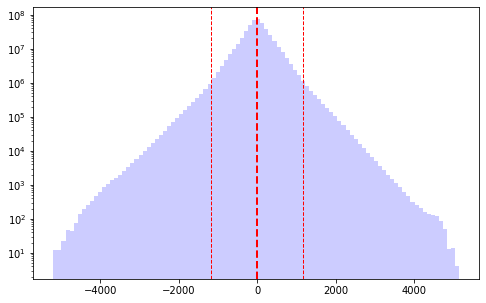

In [10]:

plt.figure(figsize=(8, 5))
plt.hist(train_data_full.flatten(), bins=100, color = 'b', alpha=0.2)

plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
plt.axvline(mean + 3*std, color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean - 3*std, color='r', linestyle='dashed', linewidth=1)
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(train_data_full.flatten(), bins=100, log=True, color = 'b', alpha=0.2)

plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
plt.axvline(mean + 3*std, color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean - 3*std, color='r', linestyle='dashed', linewidth=1)
plt.show()


Please notice the log distribution is much more evenly spread than original values, from which we can conclude the image/train data contains non-uniform a few high frequency values probably concentrated around mean (definetly is from seeing the graph). </br>
Also the values are not skewed around mean, rather evenly splitted. 

Now let's take a look at how the label distribution looks like. 

1 ::: mean is -0.8623 ::: std is 213.2 ::: Basement/other
2 ::: mean is 0.9905 ::: std is 379.5 ::: Slope Mudstone A
3 ::: mean is -5.073 ::: std is 468.9 ::: Mass Transport Deposit
4 ::: mean is 2.11 ::: std is 453.0 ::: Slope Mudstone B
5 ::: mean is -18.73 ::: std is 655.1 ::: Slope Valley
6 ::: mean is 1.998 ::: std is 372.3 ::: Submarine Canyon System


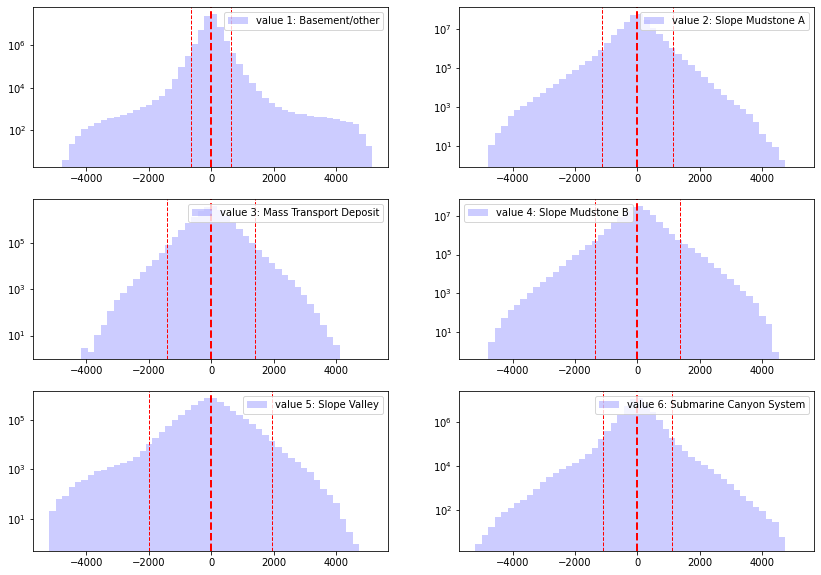

In [ ]:
CLASS_LABELS = [
    'Basement/other',
    'Slope Mudstone A',
    'Mass Transport\n Deposit',
    'Slope Mudstone B',
    'Slope Valley',
    'Submarine Canyon\n System'
]

fig, ax = plt.subplots(3, 2, figsize=(14, 10))

for i, value in enumerate(values):
    data = data_histograms[i]
    mean_, std_ = data.mean(), data.std()
    ax_ = ax[i // 2, i % 2]
    
    label_name = CLASS_LABELS[value-1].replace('\n', '')
    
    ax_.hist(data, log=True, bins=50, range=ranges, color='b',
                     label=f'value {value}: {label_name}', alpha=0.2)
    ax_.axvline(mean_, color='r', linestyle='dashed', linewidth=2)
    ax_.axvline(mean_ + 3*std_, color='r', linestyle='dashed', linewidth=1)
    ax_.axvline(mean_ - 3*std_, color='r', linestyle='dashed', linewidth=1)
    
    ax_.legend(loc='best')
    
    print(f'{value}) mean is {mean_:4.4} and std is {std_:4.4} for label: {label_name}')

fig.show()

Above we looked at individual labels distribution along with its mean,std ranges. The 6 values look more or less the same with a few changes. Now, we are going to visualize how a 2D slice of 3D data can be represented and we try to plot that using below code. The code is adapted from a great EDA notebook by `
dipam_chakraborty`, make sure to check out their work [here](https://www.aicrowd.com/showcase/explainer-eda-of-seismic-data-by-geographic-axis) which provides great insights as well as fun to read. 

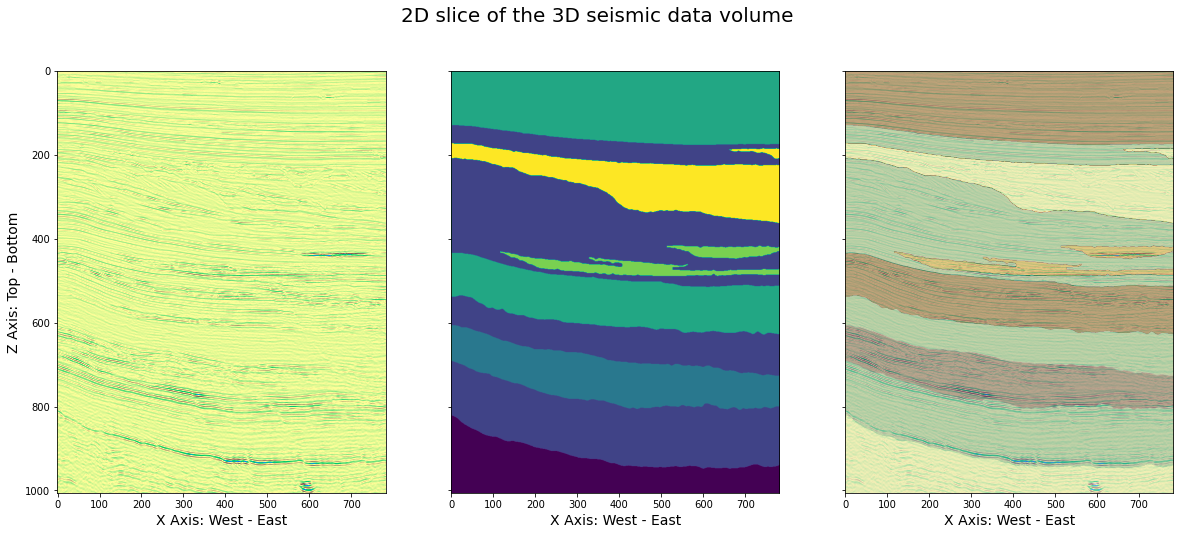

In [11]:
#let's look at 2d section of 3d data using below slice visualization 
fig, ax = plt.subplots(1,3, sharey=True);
fig.set_size_inches(20, 8);
fig.suptitle("2D slice of the 3D seismic data volume for better visualization", fontsize=20);

ax[0].imshow(train_data_full[:, :, 100], cmap='terrain');
ax[0].set_ylabel('Z Axis: Top - Bottom', fontsize=14);
ax[1].imshow(train_label_full[:, :, 100]);
ax[2].imshow(train_data_full[:, :, 100], cmap='terrain');
ax[2].imshow(train_label_full[:, :, 100], alpha=0.4, cmap='twilight');

for i in range(3):
    ax[i].set_xlabel('X Axis: West - East', fontsize=14);


## EDA - Extra attributes

Moving on with attributes, we will explore a few operations which can be used to increase number of channels in the input. Although, these addition may lead to improved performance, DL models (NNs) can approximate them and the performace advatange may not be significant (apart from some speedup during training)
</br>
Please make sure to check out in-depth EDA from this great notebook by `leocd` [here](https://www.aicrowd.com/showcase/explainer-need-extra-features-different-input-approach-try-seismic-attributes) and wonderfull work of `sergeytsimfer` can be found at [this discussion thread](https://discourse.aicrowd.com/t/explainer-eda-in-details-baseline-and-advanced-models/3745), I have used adapted version of a few attributes used by them.

Here, we are using hilbert operator to create new attribute as seen in the next cell's output. 

In [16]:
from seismiqb import plot_image, Horizon, HorizonMetrics, SeismicGeometry

In [17]:
import scipy
from scipy.ndimage import gaussian_filter1d
from scipy.signal import hilbert
from scipy.ndimage.filters import convolve

slide = train_data_full[380, :, :]

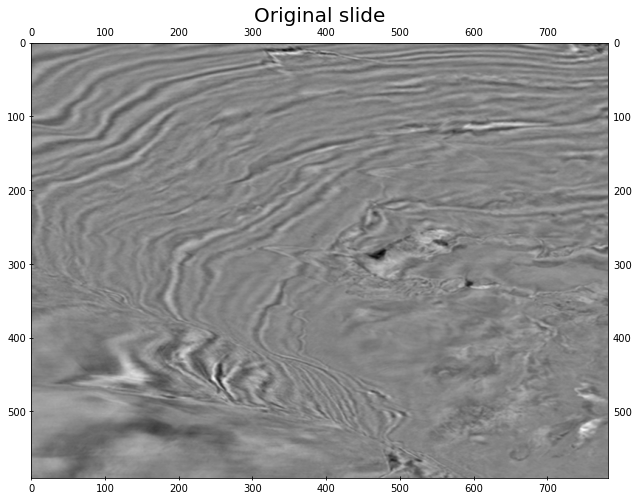

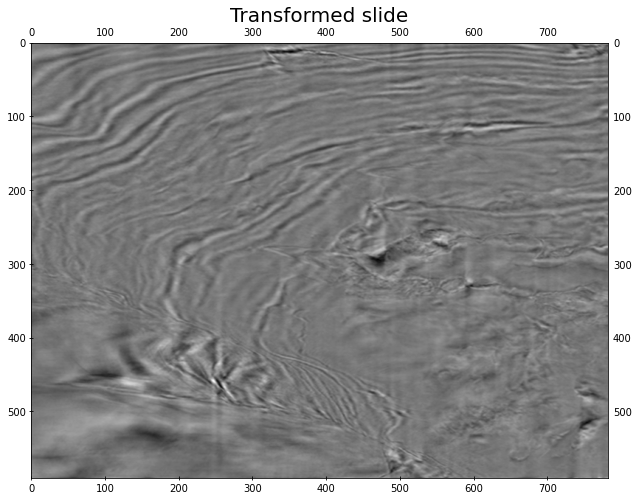

In [18]:
plot_image(slide, cmap='gray', colorbar=False, figsize=(12, 8), title='Original slide')

hilbert_scipy = hilbert(slide, axis=1)

plot_image(hilbert_scipy.imag, cmap='gray', colorbar=False, figsize=(12, 8), title='Transformed slide')

We can notice the hilbert transform has edges more visible and it provides more info if used a side channel. This attribute can be approximated by neural network and hence we are not using this attribute. 

Another way to look at the dataset is to plot SNR (Signal to noise ratio) along the depth axis for the train (or test) cube. 

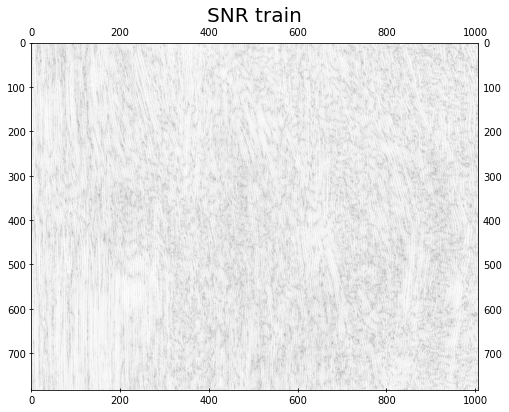

In [21]:
def plot_snr(array, **kwargs):
    mean_matrix = np.mean(array, axis=-1)
    std_matrix = np.std(array, axis=-1)
    snr = np.log(mean_matrix**2 / std_matrix ** 2)
    plot_image(snr, figsize=(8, 12), **kwargs)

plot_snr(train_data_full, title='SNR train')

We can also include RMS frequency or RMS amplitude as an additional variable, to compute RMS Freq, we first calculate cosine frequency and then use convolution operation with those freq values. After which we get a nice looking RMS freq plot which looks satisfying and contains additional info which can also be approximated by CNN hence we are delving deep into how to use that but if you are curious, try playing with preprocessed channels and plug into our simple catalyst dataset code. 

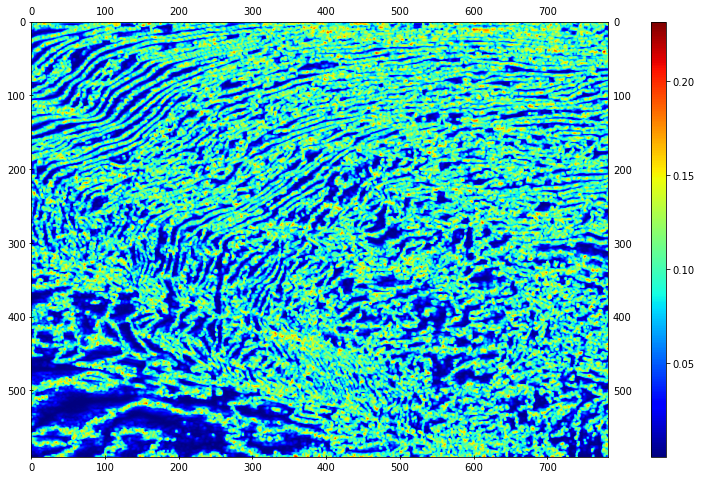

In [20]:
cos_phase = np.cos(slide / hilbert_scipy.imag)
cos_freqs = np.diff(cos_phase, axis=-1, prepend=0)

k = 3
kernel = np.ones((k, k))

rms_freqs = np.sqrt(convolve(cos_freqs**2, kernel)) / 25

plot_image(rms_freqs, cmap='jet', colorbar=True, figsize=(12, 8))

# Using Catalyst with wandb API, the final model training
This section is the heart of this notebook where I have introduced wandb along with catalyst - a rapid experimentation interface for minimal efforts and maximum efficiency. The aim of this section is to introduce the simple tools which ,needless to say, you can apply to any other competition and get quick results (in case your model training is fast, otherwise you need a 3090 or M1 Max 😉 )
Anyways, here is first part where we import datasets and preprocess them. 

In [9]:
competition_path = "/content/seismic-facies-identification-challenge/"
data_path = competition_path + "data/data/"
train_img = np.load(data_path+'data_train.npz', allow_pickle=True, mmap_mode='r')['data']
train_labels = np.load(data_path+'labels_train.npz', allow_pickle=True, mmap_mode='r')['labels']
test1_img = np.load(data_path+'data_test_1.npz', allow_pickle=True, mmap_mode='r')['data']
test2_img = np.load(data_path+'data_test_2.npz', allow_pickle=True, mmap_mode='r')['data']
train_labels -= 1
train_labels[:,0,:] = train_labels[:,1,:]

In [10]:
print(f"the shape of train_img : {train_img.shape}, train_lables : {train_labels.shape}, test1_img : {test1_img.shape}, test2_img : {test2_img.shape}")

# normalize values to max(abs())==1
_min = min(train_img.min(), test1_img.min(), test2_img.min())
_max = max(train_img.max(), test1_img.max(), test2_img.max())
divide = max(-_min, _max)
train_img = train_img / divide
test1_img = test1_img / divide
test2_img = test2_img / divide

the shape of train_img : (1006, 782, 590), train_lables : (1006, 782, 590), test1_img : (1006, 782, 251), test2_img : (1006, 334, 841)


In this part, we introduce two functions for transformation (which is augmentation here) and calculate weights to make training better/equal for all classes. 

In [11]:
def calculate_weights(train_labels):
  labels = [0, 1, 2, 3, 4, 5]
  weights = []
  for label in labels:
    weights.append(train_labels.size / np.sum(train_labels==label) / len(labels))
  return weights
def train_transform(image, mask):
    height = 896
    width = 256
    return A.Compose([   
    #here we apply augmentation for our 
    A.ShiftScaleRotate(p=0.7, shift_limit=0, scale_limit=0.15, rotate_limit=25),
    A.RandomCrop(p=1, height=height, width=width),
    A.MultiplicativeNoise(p=0.7, multiplier=(0.8, 1.2), per_channel=False, elementwise=False),
    A.HorizontalFlip(p=0.5),
  ])(image=image, mask=mask)

def valid_transform(image, mask):
    height = 1024
    width = 800
    return A.Compose([
    A.PadIfNeeded(p=1, min_height=height, min_width=width), # border_mode=4 reflect_101 
  ])(image=image, mask=mask)

This part introduces two data generators from pytorch api, one for training, another for inference. We can see the corresponding augmentation/transform function is applied here. 

In [12]:
#we create dataset pytorch class for image handling and data loading during training
class SeismicFaciesDataset(Dataset):
  def __init__(self, img, labels, train=True, both_axis=True, channels=3):
    self.img = img
    self.labels = labels
    self.train = train
    self.both_axis = both_axis
    self.channels = channels
    self.side_channels = int((channels - 1) / 2)
    self.xaxis = self.img.shape[1]
    self.yaxis = self.img.shape[2]
    self.ximages = self.xaxis - self.side_channels * 2
    self.yimages = self.yaxis - self.side_channels * 2

  def __len__(self):
    if self.both_axis:
      return self.ximages + self.yimages
    else:
      return self.yimages

  def __getitem__(self, idx):
    if idx < self.yimages:
      image, mask = self.img[:, :, idx:idx+self.channels], self.labels[:, :, idx+self.side_channels]
    else:
      idx = idx - self.yimages
      image, mask = self.img[:, idx:idx+self.channels], self.labels[:, idx+self.side_channels]
      image = np.moveaxis(image, 1, 2)

    if self.train:
      augmented = train_transform(image, mask)
    else:
      augmented = valid_transform(image, mask)
    image, mask = augmented['image'], augmented['mask']
        
    return [np.moveaxis(image, 2, 0), np.expand_dims(mask, 0)]

#separate dataset class for test images
class SeismicFaciesTestset(Dataset):
  def __init__(self, img, batch_axis=2, channels=3): # batch_axis = 1 (x_axis) or 2 (y_axis)
    self.img = img
    self.batch_axis = batch_axis
    self.channels = channels
    self.side_channels = int((channels - 1) / 2)
    self.image_nb = self.img.shape[self.batch_axis]

  def __len__(self):
    return self.image_nb

  def __getitem__(self, idx):
    if idx < self.side_channels:
      idx = self.side_channels
    
    if idx > self.image_nb-self.side_channels-1:
      idx = self.image_nb-self.side_channels-1
    if self.batch_axis == 2:
      image = self.img[:, :, idx-self.side_channels:idx+self.side_channels+1]
    else:
      image = self.img[:, idx-self.side_channels:idx+self.side_channels+1, :]
      image = np.moveaxis(image, 1, 2)

    #image = A.PadIfNeeded(p=1, min_height=1024, min_width=800)(image=image)["image"]
    bboxes = [[0, 0, image.shape[1], image.shape[0], "original_image"]] # width and then height
    augmented = A.Compose([
          A.PadIfNeeded(p=1, min_height=1024, min_width=1024),
          ], bbox_params=A.BboxParams(format='coco'))(image=image, bboxes=bboxes)
    image, self.bboxes = augmented["image"], augmented["bboxes"]
    return [np.moveaxis(image, 2, 0)]

Next part is catalyst Runner class implementation which takes care of everything we define in training loop as well as tracking our progress using logger, We used wandb logger in our case to share our results online but other loggers are also available. They can be found at [this doc page](https://catalyst-team.github.io/catalyst/api/loggers.html) 
Here we defined SMP model which is `Deeplabv3+ with backbone efficientnet-b0` and works fine for our dataset, we used weighted cross entropy loss and adam optimizer for this  run. 
All the results of this notebook can be found at [wandb run page](https://wandb.ai/jeromepatel/seismic_catalyst_wandb?workspace=user-jeromepatel) which I made public, please make sure to check that out. It also provides hardware info such as CPU, GPU usage that is useful in optimizing the training process (and hyperparameters). It provides training environment info and training run results visualization. 
Finally, we have not used artifect feature of wandb but that can be used to save our model data throughout the run. In our case catalyst provides log data and saves model so I didn't think it was necessary but you can try.

In [13]:
#this class represents catalyst Runner Class which we will be using to perform  all the required training steps, we just need to change this class in case of training parameter/process modification. 
class CustomRunner(dl.IRunner):
    def __init__(self, logdir, device):
        super().__init__()
        self._logdir = logdir
        self._device = device
        self._name = "seismic-facies-identification"
        self.classes = 6
        self.channels = 1
        self._weights = [1, 1, 1, 1, 20, 20]

    def get_engine(self):
        return dl.DeviceEngine(self._device)

    #here's where we define Weights and biases 
    def get_loggers(self):
        return {"wandb": dl.WandbLogger(project="seismic_catalyst_wandb", name=self._name)}
    
    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = {
            key: metrics.AdditiveValueMetric(compute_on_call=False)
            for key in ["loss", "accuracy_01",  "f1_score"]
        }

    @property
    def stages(self):
        return ["train_freezed", "train_unfreezed"]

    def get_stage_len(self, stage: str) -> int:
        return 10

    def get_loaders(self, stage: str):
        # train
        valid_ratio = 0.1
        dataset = SeismicFaciesDataset(train_img, train_labels, channels=self.channels)
        nb_valid_xaxis = int(dataset.xaxis * valid_ratio)
        nb_valid_yaxis = int(dataset.yaxis * valid_ratio)
        # split (train set = whole data; valid set = near to test set)
        train_index = list(range(0, dataset.__len__()))
        valid_index = list(range(dataset.__len__() - nb_valid_xaxis, dataset.__len__()))

        train_dataset, valid_dataset = Subset(dataset, train_index), Subset(copy(dataset), valid_index)
        loaders = {
         "train": DataLoader(train_dataset, batch_size=8, num_workers=0, shuffle=True, drop_last=True),
         "valid": DataLoader(valid_dataset, batch_size=4, num_workers=0, shuffle=False, drop_last=False),
        }
        return loaders

    def get_model(self, stage: str):
        model = smp.DeepLabV3Plus(encoder_name="efficientnet-b0", in_channels=self.channels, classes=self.classes, activation="softmax", encoder_weights='imagenet')
        return model

    def get_criterion(self, stage: str):
        return nn.CrossEntropyLoss(weight=torch.FloatTensor(self._weights).cuda())

    def get_optimizer(self, stage: str, model):
        if stage == "train_unfreezed":
            return optim.Adam(model.parameters(), lr=1e-3)
        else:
            return optim.SGD(model.parameters(), lr=1e-1)

    def get_scheduler(self, stage: str, optimizer):
        return None

    def get_callbacks(self, stage: str):
        callbacks = {
            "checkpoint": dl.CheckpointCallback(
                self._logdir, loader_key="valid", metric_key="loss", minimize=True, save_n_best=3
            ),
            # "criterion": dl.CriterionCallback(
            #     metric_key="loss", input_key="logits", target_key="targets"
            # ),
            # "optimizer": dl.OptimizerCallback(
            #     metric_key="loss",
            #     grad_clip_fn=nn.utils.clip_grad_norm_,
            #     grad_clip_params={"max_norm": 1.0},
            # ),
        }
        return callbacks

    def handle_batch(self, batch):
        # model train/valid step
        x, y = batch
        y_hat = self.model(x)

        loss = self.criterion(y_hat, torch.squeeze(y.long()))
        y_hat_reshaped = y_hat.permute(0, 2, 3, 1).reshape(-1, self.classes)
        y_reshaped = y.permute(0, 2, 3, 1).reshape(-1, 1)
        accuracy01, accuracy03 = catalyst.metrics.accuracy(y_hat_reshaped, y_reshaped, topk=(1, 3))
        f1_score = catalyst.metrics.f1_score(torch.argmax(y_hat_reshaped, dim=1, keepdims=True), y_reshaped, num_classes=self.classes)

        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat,
        }

        self.batch_metrics.update(
            {"loss": loss, "accuracy_01": accuracy01, "f1_score": torch.mean(f1_score)} # "accuracy_2": accuracy02, "f1_score": f1_score
        )

        for key in ["loss", "accuracy_01", "f1_score"]:
            self.meters[key].update(self.batch_metrics[key].item(),
                                    self.batch_size)
        
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

    def on_loader_end(self, runner):
        for key in ["loss", "accuracy_01", "f1_score"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)
        

In [ ]:
#running the actual model training part, cuda:0 is for using GPU, to run this code on CPU replace it with 'cpu'
runner = CustomRunner("./logs", "cuda:0")
runner.run()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/catalyst/core/runner.py:624: UserWarning:

No ``ICriterionCallback/CriterionCallback`` were found while runner.criterion is not None.Do you compute the loss during ``runner.handle_batch``?

/usr/local/lib/python3.7/dist-packages/catalyst/core/runner.py:630: UserWarning:

No ``IOptimizerCallback/OptimizerCallback`` were found while runner.optimizer is not None.Do run backward pass during ``runner.handle_batch``?

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Top best models:
logs/train_freezed.10.pth	1.0906
logs/train_freezed.9.pth	1.0942
logs/train_freezed.8.pth	1.0965
Top best models:
logs/train_unfreezed.10.pth	1.0564
logs/train_unfreezed.9.pth	1.0572
logs/train_unfreezed.8.pth	1.0574


#Alternate Solution - Custom training loop (`leocd` starter notebook)
Above code gives a nice start to the beginner for this competition but I feel that most of us have already started or near the end of our experiments, thus, for those of us who have used elegant and awesome notebook by `leocd` presented [here](https://www.aicrowd.com/showcase/explainer-introduction-and-general-approach-final-pack), they can also integrate the wandb using next code section. This part is flexible and can be adapted to any training code where the loop is customized and we need more control and flexibility.  

* First we need to login using its loging command from terminal, python alternative function can also be found for the same in [docs](https://docs.wandb.ai/guides/track). wandb also incorporates saving models, hyperparameters and even automated hyperparameter optimization using sweeps functions. For the sake of simplicity we only used simple logging and basic setting for our project above but you can surely include many more things according to your need. Your customization can greatly increase productivity and experimentation speed when using wandb and catalyst so make sure to check their respective website out for more details. 

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#use this code in case your challenge code/process is different than mine and you don't want to use catalyst. This code is modified code of starter notebook from 
@leocd, make 
#init weights and baises
import wandb

wandb.init(project='seismic-facies-AIcrowd-pytorch',
           config = {'batch_size': batch_size,      
                        'num_epochs' :num_epochs ,     
                        'num_classes': num_classes,       
                        'learning_rate': learning_rate })

for epoch in range(1, num_epochs + 1):
    ...
    for i, (data, label) in tqdm(enumerate(train_loader), total=len(train_loader), smoothing=0.9):
        data = data.to(device)
        ...
        acc_train += acc
        #add logging to your wandb project
        if i % 20 == 19:    # print every 20 batches/mini batches according to your setting
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, train_loss))
            wandb.log({'epoch': epoch+1, 'train_loss': train_loss})
            running_loss = 0.0
        
    model.eval()
    ...
    print('Epoch: {} \tTrain Loss: {:.3f} \tVal. Loss: {:.3f} \tF1_train: {:.3f} \tF1_test: {:.3f} \tF1u_test: {:.3f}'.format(
        epoch, train_loss, valid_loss, F1_train, F1_test, F1uw_test))

In [ ]:
#lastly, don't forget to finish the wandb run, it will complete the above initiated process
wandb.finish()

# Conclusion:
This notebook aims to introduce two tools for rapid experimentation and better configuration for your training, I propose catalyst and wandb in this competition which gives decent score with the same flexibility of custom training loop. 
I also tried to summarize important EDA and extra attributes but only as a brief section as I feel that most of the existing works have already done a beautiful job of explaining the data exploration part. I learnt a lot of new things along the way and would like to thank you for sharing your wonderful work in this challenge. 
Finally, thank you for reading, if you have any queries, please make sure to write in the comments and don't forget to share/like because it motivates me to learn new things and share it with you. Cheers!!!

# References:
* [[Explainer] Introduction and General Approach Final Pack! ](https://www.aicrowd.com/showcase/explainer-introduction-and-general-approach-final-pack)
* [3rd place solution](https://www.aicrowd.com/showcase/3rd-place-solution)
* [[Explainer] EDA in details, baseline and advanced models](https://www.aicrowd.com/showcase/explainer-eda-in-details-baseline-and-advanced-models)
* [[Explainer] - EDA of Seismic data by geographic axis](https://www.aicrowd.com/showcase/explainer-eda-of-seismic-data-by-geographic-axis)
* [[Explainer]: Seismic Facies Identification Starter Pack](https://www.aicrowd.com/showcase/explainer-seismic-facies-identification-starter-pack)
* [CatalystXwandb](https://colab.research.google.com/drive/1PD0LnXiADCtt4mu7bzv7VfQkFXVrPxJq?usp=sharing#scrollTo=Koa6d_hlT2vC)
* [wandb](https://docs.wandb.ai/quickstart)